### PCA

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.decomposition import PCA, SparsePCA
from sklearn.covariance import empirical_covariance

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

import seaborn as sns
import joblib
import os

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category

In [3]:
rng = 42

In [4]:
p = '../data/'
input_name = 'cleaned.csv'

df = pd.read_csv(f'{p}{input_name}')

In [5]:
# set up folder to save results
#os.makedirs('export_run5_PCA')
prefix = 'export_run5_PCA/export'

In [6]:
def df_filtering(df, i_e = 'I', f_cols = []):

    filtered_df = df[df.i_e == i_e]
    filtered_df = filtered_df[f_cols+['act']]
    
    return filtered_df

def data_split(df):
    X, y = df.iloc[:,:-1], df.iloc[:,-1:]
    y = np.where(y['act']=='R',1,0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng, stratify=y) 
    
    return X_train, X_test, y_train, y_test

In [65]:
len(export_df.columns)

17

In [7]:
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd',
                 'qty', 'unit', #'cartons',
                 'value', 'ship_date_mm']

export_df = df_filtering(df, i_e = 'E', f_cols = feature_cols)
X_train, X_test, y_train, y_test = data_split(export_df)

In [8]:
X_train.head()

,species_code,wildlf_desc,specific_generic_name,genus,species,wildlf_cat,ctry_org,ctry_ie,purp,src,trans_mode,pt_cd,qty,unit,value,ship_date_mm
65575,PINM,TRI,GREAT PEARL OYSTER,PINCTADA,MARGARITIFERA,MOL,PF,JP,T,W,A,BA,1.0,NO,0.0,5
126087,ALLM,SPE,AMERICAN ALLIGATOR,ALLIGATOR,MISSISSIPPIENSIS,REP,US,TT,M,W,A,MI,14.0,NO,2320.0,4
486033,PIMX,JWL,GOLD-LIP OYSTER,PINCTADA,MAXIMA,MOL,MX,HK,T,W,A,HA,1.0,NO,53.0,1
798703,MOLL,LIV,SHELLS MOLLUSCS,NaN_genus,NaN_species,MOL,VS,CA,T,W,A,LA,350.0,NO,208.0,12
392269,WDER,SKI,WHITE-TAILED DEER,ODOCOILEUS,VIRGINIANUS,MAM,US,CN,T,W,O,NW,744.0,NO,22190.0,2


In [9]:
X_train.shape

(224505, 16)

#### Option 1: TargetEncoding on Categorical and RobustScaler on Numeric Cols

In [10]:
numerical_var = ['value', 'qty', 'ship_date_mm'] # <- added ship_date_mm
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit']

ct_target = make_column_transformer(
    (StandardScaler(), numerical_var), # <- changed to standard
    (TargetEncoder(), categorical_var),
    remainder='passthrough')

In [11]:
X_train_t = ct_target.fit_transform(X_train, y_train)
X_test_t = ct_target.transform(X_test)

In [12]:
X_train_t[:2]

array([[-1.11761166e-01, -1.41236740e-02, -3.84762007e-01,
         1.17187500e-03,  1.41166405e-02,  1.17187500e-03,
         3.24858757e-03,  1.04239055e-03,  4.55603725e-03,
         0.00000000e+00,  6.34431783e-03,  8.38549976e-03,
         7.48914176e-03,  5.48979767e-03,  3.54484225e-04,
         8.36848617e-03],
       [-9.56524672e-02, -1.40663713e-02, -6.92312154e-01,
         5.99026582e-03,  3.08513794e-03,  5.99026582e-03,
         5.99026582e-03,  5.99026582e-03,  9.32896890e-03,
         7.68923905e-03,  9.43396226e-03,  3.24745616e-03,
         7.48914176e-03,  5.48979767e-03,  5.40807723e-03,
         8.36848617e-03]])

#### Option 2: TargetEncoding on Categorical and RobustScaler on all

In [59]:
numerical_var = ['value', 'qty'] # <- added ship_date_mm
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit', 'ship_date_mm']


ct_target = make_column_transformer(
    (TargetEncoder(), categorical_var),
    #(RobustScaler(), feature_cols),    #operation is parallelized and concatenated together
    remainder='passthrough')

pipe = Pipeline([('targetEncoding', ct_target), 
                 ('standardScaler', StandardScaler()) # <- changed to standard
                ], verbose=False)

In [60]:
X_train_t = pipe.fit_transform(X_train, y_train)
X_test_t = pipe.transform(X_test)

In [61]:
X_train_t[:2]

array([[-0.22878276,  0.47090855, -0.24492625, -0.21997912, -0.44523195,
        -0.74137561, -0.37576451, -0.33087877, -0.03731943, -0.04926299,
        -0.3408816 , -0.75649171, -0.05605808, -0.38476201, -0.01412367,
        -0.11176117],
       [-0.07709861, -0.46656331, -0.0835635 , -0.10568989, -0.15180395,
         0.13752048, -0.03913527,  0.12647017, -1.00640272, -0.04926299,
        -0.3408816 , -0.29146118, -0.05605808, -0.69231215, -0.01406637,
        -0.09565247]])

#### PCA

In [63]:
# checking out the transformed data
X_train_t_df = pd.DataFrame(X_train_t, columns=X_train.columns)
X_train_t_df.describe()

,species_code,wildlf_desc,specific_generic_name,genus,species,wildlf_cat,ctry_org,ctry_ie,purp,src,trans_mode,pt_cd,qty,unit,value,ship_date_mm
count,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05
mean,-8.249614e-17,9.484101e-16,3.236179e-17,2.575681e-16,-6.859876e-16,-2.011917e-16,-6.902871e-16,5.538985e-16,1.141172e-16,1.962047e-16,-1.214546e-15,-6.581844e-16,1.036664e-15,7.705541e-16,-2.532172e-15,-3.029022e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.656737e-01,-7.287425e-01,-2.841711e-01,-3.553993e-01,-5.070497e-01,-1.580332e+00,-3.757645e-01,-1.270005e+00,-1.618903e+00,-3.864428e-01,-9.458122e-01,-7.891113e-01,-2.285216e+00,-1.614963e+00,-1.412808e-02,-1.117612e-01
25%,-2.329431e-01,-3.815407e-01,-2.373334e-01,-2.561177e-01,-3.938127e-01,-7.413756e-01,-1.886736e-01,-4.488603e-01,-3.731943e-02,-1.215290e-01,-3.408816e-01,-5.002340e-01,-5.605808e-02,-6.923122e-01,-1.411927e-02,-1.113654e-01
50%,-1.547584e-01,-2.050792e-01,-1.661786e-01,-1.511417e-01,-2.428901e-01,1.375205e-01,-3.913527e-02,-1.273470e-01,-3.731943e-02,-4.926299e-02,-3.408816e-01,-2.034979e-01,-5.605808e-02,-7.721186e-02,-1.408400e-02,-1.089838e-01
75%,-1.727611e-02,1.025272e-01,-1.992388e-02,-4.615699e-02,9.289255e-02,7.619365e-01,-3.913527e-02,-1.273470e-01,-3.731943e-02,-4.926299e-02,-3.408816e-01,2.423685e-01,-5.605808e-02,8.454386e-01,-1.368729e-02,-8.527902e-02
max,3.120411e+01,6.604665e+01,3.319362e+01,3.668640e+01,4.298443e+01,6.615395e+01,1.572790e+01,3.090965e+01,6.256824e+00,1.672210e+01,3.446883e+00,8.035580e+01,1.798247e+01,1.768089e+00,4.407762e+02,1.668425e+02


In [43]:
pca = PCA(random_state=rng)
X_train_pca = pca.fit_transform(X_train_t)
print(X_train_t.shape, X_train_pca.shape)

(224505, 16) (224505, 16)


In [44]:
# updated to handle any number of components
def plot_pca(pca, f_names):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
    feature_names=f_names
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
    plt.yticks(np.arange(0., pca.n_components_, 1), ['PC'+str(i) for i in range(1, pca.n_components_+1)], fontsize = 16)
    plt.colorbar()

<AxesSubplot:>

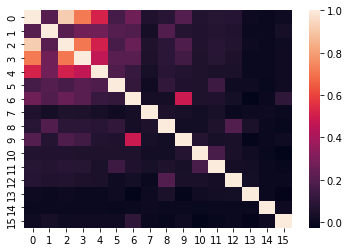

In [45]:
sns.heatmap(empirical_covariance(X_train_t))

<AxesSubplot:>

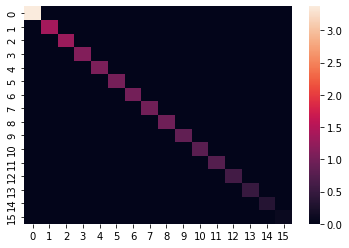

In [46]:
sns.heatmap(empirical_covariance(X_train_pca))

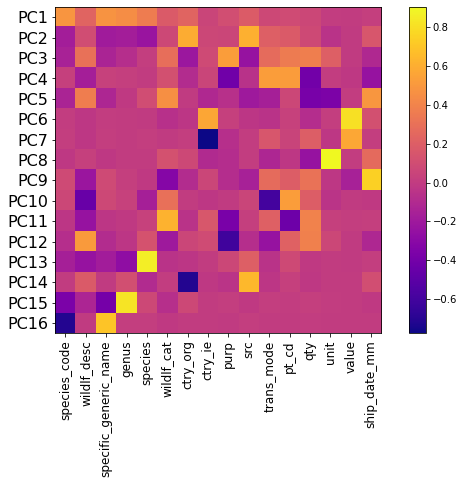

In [47]:
plot_pca(pca, feature_cols)

In [48]:
print("explained_variance_ratio:", pca.explained_variance_ratio_)
print("sum of explained variance ratios:", np.sum(pca.explained_variance_ratio_))
print("singular values:", pca.singular_values_)  

explained_variance_ratio: [0.21081876 0.08488586 0.08122736 0.06979721 0.06593611 0.06285543
 0.06198088 0.06106947 0.06004155 0.05288176 0.04860532 0.04641892
 0.03639514 0.03072592 0.02136583 0.00499447]
sum of explained variance ratios: 1.0
singular values: [870.21711991 552.19272478 540.16217765 500.71664287 486.67010613
 475.16496422 471.8477377  468.36570745 464.4071997  435.83887499
 417.84472601 408.33868658 361.57191249 332.21973242 277.03385714
 133.94229646]


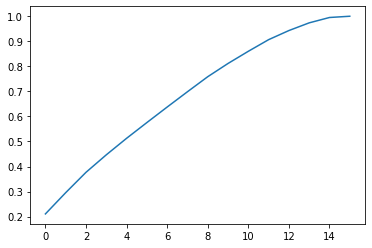

In [49]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

0     0.210819
1     0.295705
2     0.376932
3     0.446729
4     0.512665
5     0.575521
6     0.637502
7     0.698571
8     0.758613
9     0.811494
10    0.860100
11    0.906519
12    0.942914
13    0.973640
14    0.995006
15    1.000000
Name: explained var ratio, dtype: float64

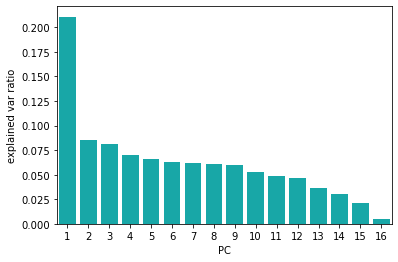

In [50]:
df = pd.DataFrame({'explained var ratio':pca.explained_variance_ratio_,
                   'PC':[str(i) for i in range(1, pca.n_components_+1)]}) # updated to handle any number of components
sns.barplot(x = 'PC',y = "explained var ratio", data = df, color="c");
np.cumsum(df['explained var ratio'])

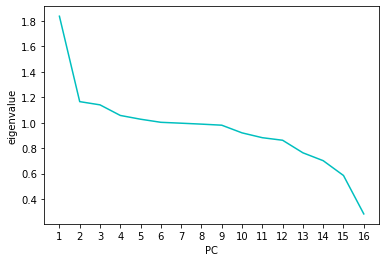

In [51]:
df = pd.DataFrame({'eigenvalue': np.sqrt(pca.explained_variance_),
                   'PC':[str(i) for i in range(1, pca.n_components_+1)]}) # updated to handle any number of components
sns.lineplot(x = 'PC',y = "eigenvalue", data = df, color="c");

#### Archive - do not run 

In [57]:
# checking out the transformed data
X_train_t_df = pd.DataFrame(X_train_t, columns=X_train.columns)
X_train_t_df.describe() 

#numerical shipment encoding

,species_code,wildlf_desc,specific_generic_name,genus,species,wildlf_cat,ctry_org,ctry_ie,purp,src,trans_mode,pt_cd,qty,unit,value,ship_date_mm
count,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05,2.245050e+05
mean,-8.249614e-17,9.484101e-16,3.236179e-17,2.575681e-16,-6.859876e-16,-2.011917e-16,-6.902871e-16,5.538985e-16,1.141172e-16,1.962047e-16,-1.214546e-15,-6.581844e-16,1.036664e-15,-2.532172e-15,-3.029022e-16,7.705541e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.656737e-01,-7.287425e-01,-2.841711e-01,-3.553993e-01,-5.070497e-01,-1.580332e+00,-3.757645e-01,-1.270005e+00,-1.618903e+00,-3.864428e-01,-9.458122e-01,-7.891113e-01,-2.285216e+00,-1.412808e-02,-1.117612e-01,-1.614963e+00
25%,-2.329431e-01,-3.815407e-01,-2.373334e-01,-2.561177e-01,-3.938127e-01,-7.413756e-01,-1.886736e-01,-4.488603e-01,-3.731943e-02,-1.215290e-01,-3.408816e-01,-5.002340e-01,-5.605808e-02,-1.411927e-02,-1.113654e-01,-6.923122e-01
50%,-1.547584e-01,-2.050792e-01,-1.661786e-01,-1.511417e-01,-2.428901e-01,1.375205e-01,-3.913527e-02,-1.273470e-01,-3.731943e-02,-4.926299e-02,-3.408816e-01,-2.034979e-01,-5.605808e-02,-1.408400e-02,-1.089838e-01,-7.721186e-02
75%,-1.727611e-02,1.025272e-01,-1.992388e-02,-4.615699e-02,9.289255e-02,7.619365e-01,-3.913527e-02,-1.273470e-01,-3.731943e-02,-4.926299e-02,-3.408816e-01,2.423685e-01,-5.605808e-02,-1.368729e-02,-8.527902e-02,8.454386e-01
max,3.120411e+01,6.604665e+01,3.319362e+01,3.668640e+01,4.298443e+01,6.615395e+01,1.572790e+01,3.090965e+01,6.256824e+00,1.672210e+01,3.446883e+00,8.035580e+01,1.798247e+01,4.407762e+02,1.668425e+02,1.768089e+00


In [52]:
numerical_var = ['value', 'qty']
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit']


ct_target = make_column_transformer(
    (TargetEncoder(), categorical_var),
    (StandardScaler(), numerical_var),
    remainder='passthrough')